# Setup

In [1]:
import multiprocessing as mp

from transformers import AutoTokenizer, BertForMaskedLM
import torch
import os
import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.metrics import classification_report, confusion_matrix

In [2]:
home_path = "../zeste/"

In [3]:
numberbatch = pickle.load(open(home_path+"numberbatch-en-19.08-en.pickle", 'rb'))

In [4]:
def get_word_neighborhood(word, depth=2, allowed_rels=['isa', 'relatedto', 'synonym'], keep='top20000'):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if word in numberbatch and ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity(word, ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [5]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [6]:
def get_words_neighborhood(words, depth=2, allowed_rels=['isa', 'relatedto', 'synonym'], keep='top20000'):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [7]:
mapping = {  'alt.atheism': 'atheism', # 'atheism',
             'comp.graphics': 'graphic',
             'comp.os.ms-windows.misc': 'windows',
             'comp.sys.ibm.pc.hardware': 'hardware',
             'comp.sys.mac.hardware': 'hardware',
             'comp.windows.x': 'windows',
             'misc.forsale': 'sale',
             'rec.autos': 'car',
             'rec.motorcycles': 'motorcycle',
             'rec.sport.baseball': 'baseball',
             'rec.sport.hockey': 'hockey',
             'sci.crypt': 'cryptography',
             'sci.electronics': 'electronics',
             'sci.med': 'medicine',
             'sci.space': 'space',
             'soc.religion.christian': 'christianity',
             'talk.politics.guns': 'gun',
             'talk.politics.mideast': 'middle_east',
             'talk.politics.misc': 'politics',
             'talk.religion.misc': 'religion' }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

18
['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']


In [8]:
ls .

 cm_20ng.pdf
'GPU2- Pipeline-Alison-classification-aspects.ipynb'
'GPU3 - Pipeline-Alison-classification.ipynb'
 hg_Zero_Shot_Pipeline.ipynb
 mono_poly_semcor_experiments_data_en.pkl
 neighborhood20k_20ng_hockey_motorcycle.pickle
 neighborhood20k_20ng_hockey_no_prompt.pickle
 neighborhood20k_20ng_is_about_definition_yahoo.pickle
 neighborhood20k_20ng_is_about_domain_deberta.pickle
 neighborhood20k_20ng_is_about_domain.pickle
 neighborhood20k_20ng_is_about_domain_XLM-RoBERTa-large-XNLI-ANLI.pickle
 neighborhood20k_20ng_is_about_domain_yahoo.pickle
 neighborhood20k_20ng_is_about_gpt0_yahoo.pickle
 neighborhood20k_20ng.pickle
 neighborhood20k_csi_base_bis.pickle
 neighborhood20k_csi_base_prompt_gpt_def.pickle
 neighborhood20k_csi_base_prompt_is_label.pickle
 neighborhood20k_csi_default_classifier.pickle
 neighborhood20k_csi_yahoo_classifier_bis.pickle
 neighborhood20k_csi_yahoo_classifier.pickle
 polysemy_bands_semcor_experiments_data.pkl
 preprocessed_neighborhood20k_csi_base_prompt_gpt_

In [9]:
os.path.exists(home_path+'labels_cgr_20ng.pickle')

True

In [10]:
%%time

if os.path.exists(home_path+'labels_cgr_20ng.pickle'):
    labels_cgr = pickle.load(open(home_path+'labels_cgr_20ng.pickle', 'rb'))

else:
    pbar = tqdm(labels)
    labels_cgr = {}
    for label in pbar:
        pbar.set_description(label)
        labels_cgr[label] = get_words_neighborhood(label, 3, 'all', keep='top20000')

CPU times: user 2.92 s, sys: 184 ms, total: 3.1 s
Wall time: 3.1 s


In [11]:
labels_cgr['atheism'].keys()

dict_keys(['atheism', 'panentheism', 'atheistic', 'antiatheistic', 'atheistically', 'deism', 'atheologist', 'panatheism', 'apeirotheism', 'religion', 'atheistical', 'atheisms', 'antiatheist', 'tritheism', 'atheophobia', 'monotheism', 'atheist', 'learning_about_science', 'unbelief', 'agnosticism', 'omnitheism', 'theism', 'adevism', 'atheisticalness', 'deconversion', 'new_atheism', 'ultra_darwinism', 'atheology', 'tetratheism', 'polytheism', "pascal's_wager", 'pantheism', 'belief', 'god', 'secularism', 'atheophobic', 'monolatrism', 'apatheism', 'atheophobe', 'antimetaphysics', 'personal_god', 'impersonal', 'deity', 'anthropomorphized', 'physicalism', 'delusion', 'philosophy', 'metaphysics', 'antimetaphysically', 'antimetaphysical', 'anti_metaphysics', 'ametaphysics', 'positivism', 'materialism', 'antimetaphysicality', 'theophobe', 'religiophobe', 'apathy', 'apatheist', 'apathetic', 'agnostic', 'ignosticism', 'monolatry', 'monolatrous', 'ditheism', 'kathenotheism', 'henotheism', 'monolate

In [12]:
labels_cgr['atheism']['panentheism']['sim']

0.644391

In [13]:
options = {
    'model_name': 'bert-large-uncased-whole-word-masking',#'bert-base-uncased',
    'prompt': {},
}

In [14]:
['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']

['atheism',
 'baseball',
 'car',
 'christianity',
 'cryptography',
 'electronics',
 'graphic',
 'gun',
 'hardware',
 'hockey',
 'medicine',
 'middle_east',
 'motorcycle',
 'politics',
 'religion',
 'sale',
 'space',
 'windows']

In [15]:
options['prompt']['atheism'] = 'Atheism is an absence of belief in the existence of God.'
options['prompt']['baseball'] = 'Baseball is a bat-and-ball game played between two opposing teams, typically of nine players each, that take turns batting and fielding.'
options['prompt']['car'] = 'A car or automobile is a wheeled motor vehicle used for transportation. Most definitions of cars say that they run primarily on roads, seat one-to-eight people, have four wheels and mainly transport people rather than goods.'
options['prompt']['christianity'] = 'Christianity is an Abrahamic, monotheistic religion based on the life and teachings of Jesus of Nazareth. It is the world\'s largest religion.'
options['prompt']['cryptography'] = 'Cryptography or cryptology is the practice and study of techniques for secure communication in the presence of adversarial behavior.'
options['prompt']['electronics'] = 'Electronics comprises the physics, engineering, technology and applications that deal with the emission, flow and control of electrons in vacuum and matter.'
options['prompt']['graphic'] = 'Graphics are visual images or designs on some surface, such as a wall, canvas, screen, paper, or stone to inform, illustrate, or entertain. It includes a pictorial representation of data, as in design and manufacture, in typesetting and the graphic arts, and in educational and recreational software.'
options['prompt']['gun'] = 'A gun is a ranged weapon designed to use a shooting tube (gun barrel) to launch typically solid projectiles'
options['prompt']['hardware'] = 'Computer hardware includes the physical parts of a computer, such as the case, central processing unit (CPU), monitor, mouse, keyboard, computer data storage, graphics card, sound card, speakers and motherboard.'
options['prompt']['hockey'] = 'Hockey is a sport in which two teams play against each other by trying to manoeuvre a ball or a puck into the opponent\'s goal using a hockey stick'
options['prompt']['medicine'] = 'Medicine is the science and practice of caring for a patient, managing the diagnosis, prognosis, prevention, treatment, palliation of their injury or disease, and promoting their health.'
options['prompt']['middle_east'] = 'The Middle East is a geopolitical term that commonly refers to the region spanning the Levant, Arabian Peninsula, Anatolia (including modern Turkey and Cyprus), Egypt, Iran and Iraq.'
options['prompt']['motorcycle'] = 'A motorcycle, often called a motorbike, bike, or cycle, is a two- or three-wheeled motor vehicle.'
options['prompt']['politics'] = 'Politics is the set of activities that are associated with making decisions in groups, or other forms of power relations between individuals, such as the distribution of resources or status.'
options['prompt']['religion'] = 'Religion is a social-cultural system of designated behaviors and practices, morals, beliefs, worldviews, texts, sanctified places, prophecies, ethics, or organizations, that relates humanity to supernatural, transcendental, and spiritual elements.'
options['prompt']['sale'] = 'Sales are activities related to selling or the number of goods sold in a given targeted time period. The delivery of a service for a cost is also considered a sale.'
options['prompt']['space'] = 'Outer space is the expanse that exists beyond Earth and between celestial bodies.'
options['prompt']['windows'] = 'Windows is a group of several proprietary graphical operating system families, all of which are developed and marketed by Microsoft. Each family caters to a certain sector of the computing industry.'

In [361]:
options['prompt']['atheism'] = 'political atheist almost sure zyklon immediate painless method death insert soem form ethnic minority group killed mutilated exterminated history guess unusual agree holocost allowed constitution far punishment doubt recieved considered fair trial standard sure look happened japanese citizen world war prepared say let round people stick concentration camp without trial short step gassing without trial seems nazi originally intended imprison jew final solution dreamt partly afford run camp devastation caused goering total war gassed generally died malnutrition disease mathew'
options['prompt']['baseball'] = 'bonilla funny white person call comeone nigger get banned year black person call someone faggot consequence ted ted missing vital point roger lustig pointed previous response reason schott banned baseball known call think racially biased manner constant basis thought affected hiring practice bonilla hand found mentioned word single time known around criticizing homosexual different story furthermore merely athlete hire anyone schott dave pallone former umpire admitted homosexual decided assist protest mets game shea like think bonilla suspended baseball pallone hoping year suspension opinion downright ludicrous howie rose wfan said start suspending athlete mentioned derogatory word even single time whatever condition probably enough people remaining play three three game honestly truly analyze difference two case bring article think reconsider thought sean behind bag vin scully'
options['prompt']['car'] = 'car wondering anyone could enlighten car saw day door sport car looked late early called bricklin door really small addition front bumper separate rest body know anyone tellme model name engine spec year production car made history whatever info funky looking car please mail thanks brought neighborhood lerxst'
options['prompt']['christianity']='pantheism environmentalism doe anybody see current emphasis environment turned unintentionally course pantheism yes adamantly environmentalist styrofoam table service please keep mind read post wish attack environmentalism half truth least dangerous complete lie complete lie rarely readily accepted half truth lie subtly hidden powerfully offered masquerade angel light satan people loosened grip treating earth something god intricate handiwork something health future generation based treated respect think going happily leave error rejected style push people opposite error therefore earth god intricate handiwork rubbish god mother earth primarily love serve see two facet response care environment treat proper respect god intricate handiwork health future generation showing facet disregardful thing doe constitute apostle paul called becoming thing men possible mean might save say forget environment got important thing spend time putting foot mouth manner destroy credibility expressing thing important show ultimate entity creature creator show beauty glory point greater beauty glory show ultimate tapestry many cord woven infinite tapestry god give mountain greatest jonathan hayward climb love strength climbing corinthian'
options['prompt']['cryptography'] = 'need clipper cheap security sense probably lot annoyed agree assessment furthermore promotion providing greater protection bare voice quite true far however way fulfill stated goal letting wiretap terrorist drug dealer restrict stronger technique wiretap target presently strong encryption weak encryption vast majority encryption latter two class tapped weak encryption every phone encryption class merged weak encryption class introduction clipper cause target presently enjoying strong privacy give rely privacy system expressly designed deny people like doubt mere introduction scheme give government nothing stated goal preventing degradation wiretapping capability fulfilled restriction domestic cryptography restriction clipper appears sop given public mute complaint find grossly inadequate tradeoff fear public large care hate even mention gun control people seem think assault weapon nyt word sort automatic weapon caliber maybe want thing legal well people know even cryptology suspect strong cryptography could easily labeled much secrecy law abiding citizen need clinton anyone say though federal supreme court say anything constitutionality anything administration governmental agency say opinion best say opinion matter continue unless overturned court reluctant annul law regulation going length decide case ground furthermore congress get away quite bit could levy burdensome tax place enforcement hand batf seen really want case could invoke commerce clause seems likely clause get anywhere day required supreme court ruled prohibitory statute unconstitutional congress prohibited many drug textual nod commerce clause controlled substance act still stand think government could get away amanda walker pgp key finger mail eli'
options['prompt']['electronics'] = 'seeking thermocouple amplifier circuit like able amplify voltage signal output thermocouple preferably factor resulting voltage fed easily personal computer based adc data acquisition card might anyone able point reference circuit seen simple amplifier circuit sure well work practice case like something amplify sufficiently nicely used thermocouple say degree accuracy better pointer greatly appreciated'
options['prompt']['graphic'] = 'weitek robert kyanko wrote writes far low level stuff look pretty nice got quadrilateral fill command requires four point weitek address phone number like get information chip joe green harris corporation computer system division thing really scare person sense humor jonathan winter'
options['prompt']['gun'] ='rewording second amendment idea massive destructive power many modern weapon make cost accidental crimial usage weapon great weapon mass destruction need control government individual access result needle death million make right people keep bear many modern weapon non existant thanks stating coming needle say disagree every count believe individual right weapon mass destruction find hard believe support neighbor right keep nuclear weapon biological weapon nerve gas property cannot even agree keeping weapon mass destruction hand individual hope sign blank check course term must rigidly defined bill doug foxvog say weapon mass destruction mean cbw nuke sarah brady say weapon mass destruction mean street sweeper shotgun semi automatic sks rifle doubt term using quote allegedly back john lawrence rutledge say weapon mass destruction immediately follows thousand people killed year handgun number easily reduced putting reasonable restriction doe rutledge mean term read article presenting first argument weapon mass destruction commonly understood switching topic first point evidently show weapon allowed later analysis given understanding consider another class believe speak company write today special investor packet doug foxvog'
options['prompt']['hockey'] ='nhl team captain traded pittsburgh currently penguin former captain real captain lemieux playing rotate season even mario even troy loney worn pen think mike foligno captain sabre got traded leaf also rick vaive captain leaf got traded chicago steve thomas olcyzk someone speaking leaf believe darryl sittler captain torn jersey think claimed captaincy later traded flyer yeah course gretzky captain oiler traded gary'
options['prompt']['hardware'] = 'clock poll final call summary final call clock report keywords acceleration clock upgrade fair number brave soul upgraded clock oscillator shared experience poll please send brief message detailing experience procedure top speed attained cpu rated speed add card adapter heat sink hour usage per day floppy disk functionality floppy especially requested summarizing next two day please add network knowledge base done clock upgrade answered poll thanks guy kuo'
options['prompt']['medicine']='brain tumor treatment thanks people responded request info treatment astrocytomas email thank directly mail bouncing probs sean debra sharon thought publicly thank everyone thanks sure glad accidentally hit instead trying delete file last september hmmm news brian'
options['prompt']['middle_east'] = 'israeli expansion lust imho doe really matter started individual battle within arab isreal war context real question started war doe anyone doubt creation israel arab land huh war started several army invaded israel vowing drive jew sea jew wanted live peace arab stayed israel granted citizenship depends entirely define war actual fighting largely predates arab invasion deir yassin happened midapril well arab invasion said elsewhere col lorch said hagana force fighting well arab invaded month jew wanting live peace entirely arguable think easy enough show labour party leadership intention arab stayed mean expelled even stay granted citizenship expelled fighting stopped anyway joseph askew define war seiges constant attack villiages count act war jew january arab liberation army attack kfar szold men attack kfar etzion mile south jerusalem cutting supply attack yehiam western galilee kibbutz tirat tzvi mid march jewish settlement negev cut land link rest jewish population etzion group villiages near hebron cut member convoy trying supply yehiam slaughtered cutting villiage jerusalem seige cut supply route tel aviv bombed supply truck left side road day memoriam time jew killed course war since arab attacking like last week fatah launched katyusha rocket northern israel doe uprising end war begin still intifadah plo brings tank joseph askew gauche proud autumn stillness see pleiades remote thorny desert fell grief disclaimer sue see care north tent sky must end somwhere actually rather like brenda beyond pale river murmur amir'
options['prompt']['motorcycle'] = 'recommendation duc summary worth expires sat may gmt keywords ducati gts much line ducati gts model clock run well paint bronze brown orange faded leak bit oil pop hard accel shop fix trans oil leak sold bike owner want thinking like opinion please email thanks nice stable mate beemer get jap bike call axis motor tuba irwin honk therefore computrac richardson dod'
options['prompt']['politics'] = 'clayton need retract modicum respectability remaining closet view expressed herein theodore kaldis seriously believe major university rutgers remus rutgers kaldis hold view appears eyed man appeared land sighted strange resaon appointed ruler supreme power joe cipale'
options['prompt']['religion'] = 'question popular morality previous article david bold say mean rude think got hold wrong end different stick david look posting see mean intent explaining jung thought could moral god overlooked main line thought seem saying god unknowable morality unknowable yep pretty much jew understand jewish way thinking however jew believe covenant yhwh patriarch abraham moses case establishes moral code follow mankind even jew could decide boundary fall though understand sadducee believed torah required whereas pharisee ancestor modern judaism believed torah available interpretation lead understanding required morality nuance talmud essence biblical morality interface man yhwh jew christian doe necessarily indicate anything yhwh outside relationship although speculate first thing come mind man supposed created image argument committed whatever moral code follows part trying live image supposed live christ example hard pressed argue god say kind guy trouble really know created image mean heard number different opinion still come conclusion rather upset apple cart want base life script shaky foundation mix metaphor unashamedly living christ example know little jesus person recorded utterance set narrative follower small reference comtemporary historian revelation aside know christ second hand worse attempt debunk christianity although may seem way initially point trying make really bible interpret interpretation humanity guess faith relevation come inherent subjectiveness metaphysically multiple moral code absolute moral code think theologically questionable may absolute moral code undoubtably multiple moral code multiple moral code may founded absolute moral code example parent may tell child never swear child may assume parent never swears simply parent told child wrong parent may swear like trooper pub bar child wrongness child disobeys parent parent may feel inappropriate swear front child may quite happy swear front animal analogy doe quite hold water child know type parent may parent later life get gist incidentally young child considers directive absolute get older see piaget learns morality david religion sea fish cried swam clearness'
options['prompt']['sale'] = 'moving sale summary moving sale reduced price list thing forsale behalf brother moving moved already offer black decker duster plus portable hand vaccum purchased dual cassette portable player band graphic equalizer high speed dubing duo tape tape deck seems lost treble sound bet fixable purchased monolux zoom microscope magnification made japan includes case accessory purchased sunbeam hair dryer dryer put head know see salon ask bro purchased everylast speed bag leather brand new never used osterizer pusle matic blender speed cookbook year old purchased binolux binoculars extra wide angle yds case new proctor silex spray steam dry iron new question contact thru mail reply expeditously always included please consider lastly reasonable reasonable thanks john'
options['prompt']['space'] = 'shuttle launch question error wondering expected error might sorry really dumb question parity error memory previously known condition waivered yes error already knew curious real meaning quote tom understanding expected error basically known bug warning system software thing checked right value yet set till launch suchlike rather fix code possibly introduce new bug tell crew see warning liftoff ignore jonathan'
options['prompt']['windows'] = 'win icon help please win downloaded several icon bmp figure change wallpaper icon help appreciated thanx brando please mail'

In [20]:
"""alt.atheism': 'atheism', # 'atheism',
             'comp.graphics': 'graphic',
             'comp.os.ms-windows.misc': 'windows',
             'comp.sys.ibm.pc.hardware': 'hardware',
             'comp.sys.mac.hardware': 'hardware',
             'comp.windows.x': 'windows',
             'misc.forsale': 'sale',
             'rec.autos': 'car',
             'rec.motorcycles': 'motorcycle',
             'rec.sport.baseball': 'baseball',
             'rec.sport.hockey': 'hockey',
             'sci.crypt': 'cryptography',
             'sci.electronics': 'electronics',
             'sci.med': 'medicine',
             'sci.space': 'space',
             'soc.religion.christian': 'christianity',
             'talk.politics.guns': 'gun',
             'talk.politics.mideast': 'middle_east',
             'talk.politics.misc': 'politics',
             'talk.religion.misc': 'religion' }"""
                
options['prompt']['atheism'] = 'alternative'
#options['prompt']['atheism'] = 'political atheist almost sure zyklon immediate painless method death insert soem form ethnic minority group killed mutilated exterminated history guess unusual agree holocost allowed constitution far punishment doubt recieved considered fair trial standard sure look happened japanese citizen world war prepared say let round people stick concentration camp without trial short step gassing without trial seems nazi originally intended imprison jew final solution dreamt partly afford run camp devastation caused goering total war gassed generally died malnutrition disease mathew'
options['prompt']['baseball'] = 'recreational sport'#'sport'
options['prompt']['car'] = 'recreational sport'#'autos'
options['prompt']['christianity']='religion'
options['prompt']['cryptography'] = 'science'
options['prompt']['electronics'] = 'science'
options['prompt']['graphic'] = 'computer'
options['prompt']['gun'] ='talk politics'
options['prompt']['hockey'] ='recreational sport'#'sport'
options['prompt']['hardware'] = 'computer'
options['prompt']['medicine']='science'
options['prompt']['middle_east'] = 'politics'
options['prompt']['motorcycle'] = 'recreational'#'motorcycles'
options['prompt']['politics'] = 'talk politics'
options['prompt']['religion'] = 'history of religion'
#options['prompt']['religion'] = 'question popular morality previous article david bold say mean rude think got hold wrong end different stick david look posting see mean intent explaining jung thought could moral god overlooked main line thought seem saying god unknowable morality unknowable yep pretty much jew understand jewish way thinking however jew believe covenant yhwh patriarch abraham moses case establishes moral code follow mankind even jew could decide boundary fall though understand sadducee believed torah required whereas pharisee ancestor modern judaism believed torah available interpretation lead understanding required morality nuance talmud essence biblical morality interface man yhwh jew christian doe necessarily indicate anything yhwh outside relationship although speculate first thing come mind man supposed created image argument committed whatever moral code follows part trying live image supposed live christ example hard pressed argue god say kind guy trouble really know created image mean heard number different opinion still come conclusion rather upset apple cart want base life script shaky foundation mix metaphor unashamedly living christ example know little jesus person recorded utterance set narrative follower small reference comtemporary historian revelation aside know christ second hand worse attempt debunk christianity although may seem way initially point trying make really bible interpret interpretation humanity guess faith relevation come inherent subjectiveness metaphysically multiple moral code absolute moral code think theologically questionable may absolute moral code undoubtably multiple moral code multiple moral code may founded absolute moral code example parent may tell child never swear child may assume parent never swears simply parent told child wrong parent may swear like trooper pub bar child wrongness child disobeys parent parent may feel inappropriate swear front child may quite happy swear front animal analogy doe quite hold water child know type parent may parent later life get gist incidentally young child considers directive absolute get older see piaget learns morality david religion sea fish cried swam clearness'
options['prompt']['sale'] = 'sale'
options['prompt']['space'] = 'science'#'universe'
options['prompt']['windows'] = 'computer'

## Filter with the LM

In [16]:
tokenizer = AutoTokenizer.from_pretrained(options['model_name'])
bert = BertForMaskedLM.from_pretrained(options['model_name'])

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
bert_vocab = tokenizer.get_vocab()
reverse_vocab = {i:w for w,i in bert_vocab.items()}
len(bert_vocab)

30522

In [18]:
labels_mapping = {'atheism':'Atheism', 
                  'baseball':'Baseball', 
                  'car': 'A car', 
                  'christianity': 'Christianity', 
                  'cryptography': 'Cryptography', 
                  'electronics': 'Electronics', 
                  'graphic': 'Graphics', 
                  'gun': 'A gun', 
                  'hardware': 'Hardware', 
                  'hockey': 'Hockey', 
                  'medicine': 'Medicine', 
                  'middle_east': 'The Middle East', 
                  'motorcycle': 'A motorcycle', 
                  'politics': 'Politics', 
                  'religion': 'Religion', 
                  'sale': 'A sale', 
                  'space': 'Space', 
                  'windows': 'Windows'
}

In [19]:
%time
candidates_scores = {}

# options['prompt'] = 'an opening in the wall or roof of a building or vehicle that is fitted with glass or other transparent material in a frame to admit light or air and allow people to see out.'

for label in options['prompt']:
    #print(label)
    if label in options['prompt']:
    #if label=='space' or label=='windows'or label=='hardware' or label=='car' or label=='graphic' :
        template = f"{options['prompt'][label]} [SEP] {labels_mapping[label]} is about {tokenizer.mask_token}."
    else:
        template = f"{labels_mapping[label]} is about {tokenizer.mask_token}."
    tokens_idx = tokenizer.encode(template)
    #print(tokens_idx)

    # print(template, len(template))
    tokens = tokenizer.convert_ids_to_tokens(tokens_idx)

    # print(tokens, len(tokens))

    scores = bert(torch.tensor([tokens_idx]))[0][0][-3].detach().numpy()
    #factor=1.0/sum(scores)
    #for k in scores:
      #k = k*factor
    
    candidates_scores[label] = sorted([(reverse_vocab[i], s) for i,s in enumerate(scores)], key=lambda c: -c[1])
    #print(candidates_scores['atheism'])
 
    #print(factor)
    #print(label_neighborhood.values())


    # print(logits.shape)
    #print(label, '   ', candidates_scores[label][:20])

CPU times: user 50 µs, sys: 8 µs, total: 58 µs
Wall time: 6.68 µs


In [20]:
labels_cgr.keys()

dict_keys(['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows'])

In [26]:
#with open('neighborhood20k_20ng.pickle', 'rb') as f:
with open('neighborhood20k_20ng_is_about_domain_yahoo.pickle', 'rb') as f:
#with open('neighborhood20k_20ng_is_about_domain_XLM-RoBERTa-large-XNLI-ANLI.pickle', 'rb') as f:
#with open('neighborhood20k_20ng_is_about_domain_deberta.pickle', 'rb') as f:
#with open('neighborhood20k_20ng_is_about_definition_yahoo.pickle', 'rb') as f:
#with open('neighborhood20k_20ng_is_about_gpt0_yahoo.pickle', 'rb') as f:
    
    candidates_scores = pickle.load(f)
#print(candidates_scores['atheism'])"""

In [27]:
neighborhood = {}
for label in tqdm(labels_cgr):
    neighborhood[label] = {}
    dd = dict(candidates_scores[label])
    
    #dd=candidates_scores[label]
    for word in labels_cgr[label]:
        if word in dd:
            neighborhood[label][word] = (labels_cgr[label][word]['sim'], dd[word])

In [111]:
for label in neighborhood:
    total = max([x[1] for x in neighborhood[label].values()])
    for word in neighborhood[label]:
        neighborhood[label][word] = (neighborhood[label][word][0], neighborhood[label][word][1]/total)

In [89]:
#sorted([(k, d['sim']) for k, d in labels_cgr['baseball'].items()], key=lambda x: -x[1])

In [90]:
#sorted(neighborhood['atheism'].items(), key=lambda x: -x[1][0])

In [91]:
#sorted(neighborhood['atheism'].items(), key=lambda x: -x[1][1])

In [92]:
#sorted(neighborhood['christianity'].items(), key=lambda x: -x[1][1])

In [93]:
for label in neighborhood:
    print(label, ':', len(neighborhood[label]))

atheism : 19900
baseball : 19900
car : 19900
christianity : 19900
cryptography : 19900
electronics : 19900
graphic : 19900
gun : 19900
hardware : 19900
hockey : 19900
medicine : 19900
middle_east : 19900
motorcycle : 19900
politics : 19900
religion : 19900
sale : 19900
space : 19900
windows : 19900


In [94]:
print("""WITH TOP3000:
=============
atheism : 658
baseball : 487
car : 569
christianity : 539
cryptography : 426
electronics : 376
graphic : 506
gun : 535
hardware : 538
hockey : 592
medicine : 160
middle_east : 576
motorcycle : 661
politics : 560
religion : 470
sale : 640
space : 451
windows : 513
""")

WITH TOP3000:
atheism : 658
baseball : 487
car : 569
christianity : 539
cryptography : 426
electronics : 376
graphic : 506
gun : 535
hardware : 538
hockey : 592
medicine : 160
middle_east : 576
motorcycle : 661
politics : 560
religion : 470
sale : 640
space : 451
windows : 513



# Evaluation

In [95]:
ds_20ng = pd.read_csv(home_path+'datasets/20ng_preprocessed_dataset.csv')
ds_20ng.head()
ds_20ng['text'].loc[ds_20ng['label'] == 'talk.religion.misc'][11]

'question popular morality previous article david bold say mean rude think got hold wrong end different stick david look posting see mean intent explaining jung thought could moral god overlooked main line thought seem saying god unknowable morality unknowable yep pretty much jew understand jewish way thinking however jew believe covenant yhwh patriarch abraham moses case establishes moral code follow mankind even jew could decide boundary fall though understand sadducee believed torah required whereas pharisee ancestor modern judaism believed torah available interpretation lead understanding required morality nuance talmud essence biblical morality interface man yhwh jew christian doe necessarily indicate anything yhwh outside relationship although speculate first thing come mind man supposed created image argument committed whatever moral code follows part trying live image supposed live christ example hard pressed argue god say kind guy trouble really know created image mean heard n

In [96]:
#for x in ds_20ng[ds_20ng.label == 'soc.religion.christian'].text.head(5):
    #print(x)

In [97]:
mapping = {  'alt.atheism': 'atheism', # 'atheism',
             'comp.graphics': 'graphic',
             'comp.os.ms-windows.misc': 'windows',
             'comp.sys.ibm.pc.hardware': 'hardware',
             'comp.sys.mac.hardware': 'hardware',
             'comp.windows.x': 'windows',
             'misc.forsale': 'sale',
             'rec.autos': 'car',
             'rec.motorcycles': 'motorcycle',
             'rec.sport.baseball': 'baseball',
             'rec.sport.hockey': 'hockey',
             'sci.crypt': 'cryptography',
             'sci.electronics': 'electronics',
             'sci.med': 'medicine',
             'sci.space': 'space',
             'soc.religion.christian': 'christianity',
             'talk.politics.guns': 'gun',
             'talk.politics.mideast': 'middle_east',
             'talk.politics.misc': 'politics',
             'talk.religion.misc': 'religion' }

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

18
['atheism', 'baseball', 'car', 'christianity', 'cryptography', 'electronics', 'graphic', 'gun', 'hardware', 'hockey', 'medicine', 'middle_east', 'motorcycle', 'politics', 'religion', 'sale', 'space', 'windows']


In [98]:
def get_document_score(doc, label_neighborhood):
    #for name, (conceptnet_score, hg_face) in label_neighborhood.items()
    #factor=1.0/sum(hg_face for name, (conceptnet_score, hg_face) in label_neighborhood.items())
    #print(factor)
    #print(label_neighborhood.values())
    #for name, (conceptnet_score, hg_face) in label_neighborhood.items():
        #hg_face = factor*hg_face
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            if 'sim' in label_neighborhood[token]:
                similarity = label_neighborhood[token]['sim']
                #print(label_neighborhood[token])

            else:
                similarity =  label_neighborhood[token][0]*label_neighborhood[token][1]
            #print((label_neighborhood[token][0],label_neighborhood[token][1]))
            if similarity > 0:
                # related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [99]:
def scoring_document(doc, labels=labels_cgr):
    return np.argmax([get_document_score(doc, labels[l]) for l in labels])

def generate_predictions(corpus_preprocessed):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_document, corpus_preprocessed)
    return predictions


def scoring_document_pro(doc, labels=neighborhood):
    return np.argmax([get_document_score(doc, labels[l]) for l in labels])

def generate_predictions_pro(corpus_preprocessed):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_document_pro, corpus_preprocessed)
    return predictions

In [100]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [101]:
%%time
pool = mp.Pool(mp.cpu_count())
data_20ng = pool.map(preprocess, ds_20ng.text)
pool.close()

CPU times: user 1.11 s, sys: 1.96 s, total: 3.07 s
Wall time: 16.9 s


In [102]:
#get_document_score(data_20ng[0], neighborhood['car'])
print(neighborhood['religion'])

{'religion': (1.0, 9.77570250125964e-05), 'cult_site': (0.6756114, 6.730008648369721e-05), 'avestaic': (0.623436, 5.7015836884004284e-05), 'nikonian': (0.7059826, 4.9988052894476244e-05), 'deuteronomy': (0.17690398, 6.788687412071691e-05), 'protestant': (0.4018304, 7.127175246142883e-05), 'theism': (0.5995059, 8.008136261991209e-05), 'conforming': (0.14854203, 5.540901812968224e-05), 'catholicism': (0.568833, 7.452566228279048e-05), 'sun_disc': (0.41000617, 3.895970790071179e-05), 'syncretism': (0.4311095, 7.249794060135717e-05), 'ethnoreligious': (0.6077913, 7.268951441832644e-05), 'canonisation': (0.27403304, 4.4427616743329496e-05), 'spiritual_violence': (0.76378244, 3.7643578063564096e-05), 'monotheism': (0.53719765, 8.742041902057009e-05), 'twelver': (0.49709207, 6.487256428072058e-05), 'atenism': (0.48080263, 4.584150773888917e-05), 'believers': (0.43006447, 9.653182697988237e-05), 'defrocked': (0.21383213, 3.9638682869686946e-05), 'eternal_recurrence': (0.59659326, 6.32169976573

In [103]:
%%time
predictions = generate_predictions(data_20ng)
print(len(predictions))
prediction_labels = [labels[p] for p in predictions]
true_labels = [mapping[l] for l in ds_20ng.label.tolist()]

print(classification_report(prediction_labels, true_labels, digits=3))

11314
              precision    recall  f1-score   support

     atheism      0.427     0.407     0.417       504
    baseball      0.905     0.835     0.868       647
         car      0.840     0.591     0.694       845
christianity      0.698     0.608     0.650       688
cryptography      0.746     0.693     0.718       641
 electronics      0.514     0.636     0.569       478
     graphic      0.526     0.457     0.489       672
         gun      0.685     0.718     0.701       521
    hardware      0.588     0.560     0.574      1226
      hockey      0.838     0.878     0.858       573
    medicine      0.559     0.895     0.688       371
 middle_east      0.670     0.849     0.749       445
  motorcycle      0.625     0.928     0.747       403
    politics      0.447     0.466     0.457       446
    religion      0.167     0.194     0.180       324
        sale      0.491     0.408     0.446       703
       space      0.820     0.697     0.753       697
     windows      0.6

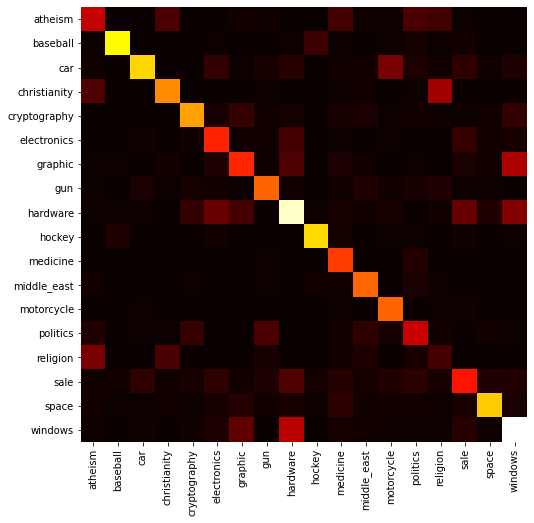

In [104]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns = labels, index = labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm_df, cmap='hot', cbar=False)

In [105]:
print("""With3000
precision    recall  f1-score   support

     atheism      0.315     0.364     0.337       415
    baseball      0.709     0.883     0.786       479
         car      0.800     0.501     0.616       949
christianity      0.629     0.590     0.609       639
cryptography      0.504     0.637     0.563       471
 electronics      0.337     0.684     0.451       291
     graphic      0.438     0.480     0.458       533
         gun      0.672     0.678     0.675       541
    hardware      0.539     0.454     0.493      1389
      hockey      0.863     0.761     0.809       681
    medicine      0.544     0.871     0.669       371
 middle_east      0.637     0.775     0.699       463
  motorcycle      0.584     0.893     0.706       391
    politics      0.411     0.389     0.400       491
    religion      0.241     0.192     0.214       473
        sale      0.542     0.364     0.436       870
       space      0.772     0.648     0.705       707
     windows      0.612     0.625     0.619      1160

    accuracy                          0.575     11314
   macro avg      0.564     0.599     0.569     11314
weighted avg      0.589     0.575     0.572     11314

CPU times: user 642 ms, sys: 2.34 s, total: 2.99 s
Wall time: 3.75 s
""")

With3000
precision    recall  f1-score   support

     atheism      0.315     0.364     0.337       415
    baseball      0.709     0.883     0.786       479
         car      0.800     0.501     0.616       949
christianity      0.629     0.590     0.609       639
cryptography      0.504     0.637     0.563       471
 electronics      0.337     0.684     0.451       291
     graphic      0.438     0.480     0.458       533
         gun      0.672     0.678     0.675       541
    hardware      0.539     0.454     0.493      1389
      hockey      0.863     0.761     0.809       681
    medicine      0.544     0.871     0.669       371
 middle_east      0.637     0.775     0.699       463
  motorcycle      0.584     0.893     0.706       391
    politics      0.411     0.389     0.400       491
    religion      0.241     0.192     0.214       473
        sale      0.542     0.364     0.436       870
       space      0.772     0.648     0.705       707
     windows      0.612     0.62

In [106]:
print('''WITH 6000:
precision    recall  f1-score   support

     atheism      0.325     0.355     0.339       439
    baseball      0.831     0.869     0.849       571
         car      0.813     0.508     0.625       951
christianity      0.656     0.594     0.623       662
cryptography      0.652     0.676     0.664       574
 electronics      0.357     0.653     0.462       323
     graphic      0.491     0.425     0.456       676
         gun      0.645     0.689     0.666       511
    hardware      0.518     0.500     0.509      1209
      hockey      0.832     0.839     0.835       595
    medicine      0.534     0.873     0.662       363
 middle_east      0.676     0.812     0.738       469
  motorcycle      0.569     0.912     0.700       373
    politics      0.409     0.410     0.409       463
    religion      0.204     0.194     0.199       396
        sale      0.540     0.362     0.433       874
       space      0.799     0.650     0.717       729
     windows      0.596     0.621     0.609      1136

    accuracy                          0.590     11314
   macro avg      0.580     0.608     0.583     11314
weighted avg      0.603     0.590     0.587     11314

CPU times: user 737 ms, sys: 2.41 s, total: 3.15 s
Wall time: 4.06 s
''')

WITH 6000:
precision    recall  f1-score   support

     atheism      0.325     0.355     0.339       439
    baseball      0.831     0.869     0.849       571
         car      0.813     0.508     0.625       951
christianity      0.656     0.594     0.623       662
cryptography      0.652     0.676     0.664       574
 electronics      0.357     0.653     0.462       323
     graphic      0.491     0.425     0.456       676
         gun      0.645     0.689     0.666       511
    hardware      0.518     0.500     0.509      1209
      hockey      0.832     0.839     0.835       595
    medicine      0.534     0.873     0.662       363
 middle_east      0.676     0.812     0.738       469
  motorcycle      0.569     0.912     0.700       373
    politics      0.409     0.410     0.409       463
    religion      0.204     0.194     0.199       396
        sale      0.540     0.362     0.433       874
       space      0.799     0.650     0.717       729
     windows      0.596     0.

In [107]:
print(""" 20000 Top words
precision    recall  f1-score   support

     atheism      0.352     0.367     0.360       460
    baseball      0.883     0.830     0.856       635
         car      0.827     0.523     0.641       939
christianity      0.688     0.589     0.635       699
cryptography      0.634     0.689     0.660       547
 electronics      0.418     0.632     0.503       391
     graphic      0.500     0.420     0.457       695
         gun      0.634     0.678     0.655       510
    hardware      0.478     0.513     0.495      1087
      hockey      0.823     0.856     0.839       577
    medicine      0.508     0.893     0.648       338
 middle_east      0.651     0.836     0.732       439
  motorcycle      0.565     0.918     0.700       368
    politics      0.452     0.420     0.435       500
    religion      0.170     0.187     0.178       342
        sale      0.549     0.370     0.442       867
       space      0.820     0.633     0.714       768
     windows      0.590     0.606     0.598      1152

    accuracy                          0.592     11314
   macro avg      0.586     0.609     0.586     11314
weighted avg      0.609     0.592     0.591     11314
""")

 20000 Top words
precision    recall  f1-score   support

     atheism      0.352     0.367     0.360       460
    baseball      0.883     0.830     0.856       635
         car      0.827     0.523     0.641       939
christianity      0.688     0.589     0.635       699
cryptography      0.634     0.689     0.660       547
 electronics      0.418     0.632     0.503       391
     graphic      0.500     0.420     0.457       695
         gun      0.634     0.678     0.655       510
    hardware      0.478     0.513     0.495      1087
      hockey      0.823     0.856     0.839       577
    medicine      0.508     0.893     0.648       338
 middle_east      0.651     0.836     0.732       439
  motorcycle      0.565     0.918     0.700       368
    politics      0.452     0.420     0.435       500
    religion      0.170     0.187     0.178       342
        sale      0.549     0.370     0.442       867
       space      0.820     0.633     0.714       768
     windows      0.590 

In [108]:
print("""With 6000 + summing the two scores
              precision    recall  f1-score   support

     atheism      0.504     0.218     0.305      1108
    baseball      0.670     0.697     0.683       574
         car      0.631     0.548     0.587       684
christianity      0.102     0.314     0.154       194
cryptography      0.539     0.510     0.524       630
 electronics      0.205     0.548     0.298       221
     graphic      0.408     0.357     0.381       666
         gun      0.518     0.618     0.564       458
    hardware      0.557     0.365     0.441      1783
      hockey      0.617     0.853     0.716       434
    medicine      0.478     0.845     0.611       336
 middle_east      0.500     0.758     0.603       372
  motorcycle      0.644     0.773     0.703       498
    politics      0.477     0.280     0.353       792
    religion      0.170     0.172     0.171       372
        sale      0.458     0.315     0.373       852
       space      0.664     0.535     0.593       736
     windows      0.233     0.457     0.309       604

    accuracy                          0.463     11314
   macro avg      0.465     0.509     0.465     11314
weighted avg      0.502     0.463     0.462     11314

CPU times: user 706 ms, sys: 2.45 s, total: 3.16 s
Wall time: 4.17 s
""")

With 6000 + summing the two scores
              precision    recall  f1-score   support

     atheism      0.504     0.218     0.305      1108
    baseball      0.670     0.697     0.683       574
         car      0.631     0.548     0.587       684
christianity      0.102     0.314     0.154       194
cryptography      0.539     0.510     0.524       630
 electronics      0.205     0.548     0.298       221
     graphic      0.408     0.357     0.381       666
         gun      0.518     0.618     0.564       458
    hardware      0.557     0.365     0.441      1783
      hockey      0.617     0.853     0.716       434
    medicine      0.478     0.845     0.611       336
 middle_east      0.500     0.758     0.603       372
  motorcycle      0.644     0.773     0.703       498
    politics      0.477     0.280     0.353       792
    religion      0.170     0.172     0.171       372
        sale      0.458     0.315     0.373       852
       space      0.664     0.535     0.593   

In [109]:
print("""With 6000 + With just BERT score
precision    recall  f1-score   support

     atheism      0.512     0.213     0.301      1154
    baseball      0.640     0.674     0.656       567
         car      0.604     0.546     0.573       658
christianity      0.077     0.253     0.118       182
cryptography      0.523     0.491     0.507       633
 electronics      0.195     0.528     0.284       218
     graphic      0.397     0.349     0.371       665
         gun      0.502     0.602     0.547       455
    hardware      0.557     0.356     0.434      1827
      hockey      0.577     0.832     0.681       416
    medicine      0.470     0.840     0.603       332
 middle_east      0.496     0.755     0.599       371
  motorcycle      0.649     0.759     0.700       511
    politics      0.473     0.277     0.349       795
    religion      0.156     0.162     0.159       364
        sale      0.439     0.299     0.356       860
       space      0.658     0.522     0.582       747
     windows      0.195     0.413     0.265       559

    accuracy                          0.448     11314
   macro avg      0.451     0.493     0.449     11314
weighted avg      0.492     0.448     0.449     11314
""")

With 6000 + With just BERT score
precision    recall  f1-score   support

     atheism      0.512     0.213     0.301      1154
    baseball      0.640     0.674     0.656       567
         car      0.604     0.546     0.573       658
christianity      0.077     0.253     0.118       182
cryptography      0.523     0.491     0.507       633
 electronics      0.195     0.528     0.284       218
     graphic      0.397     0.349     0.371       665
         gun      0.502     0.602     0.547       455
    hardware      0.557     0.356     0.434      1827
      hockey      0.577     0.832     0.681       416
    medicine      0.470     0.840     0.603       332
 middle_east      0.496     0.755     0.599       371
  motorcycle      0.649     0.759     0.700       511
    politics      0.473     0.277     0.349       795
    religion      0.156     0.162     0.159       364
        sale      0.439     0.299     0.356       860
       space      0.658     0.522     0.582       747
     win

In [110]:
%%time
predictions2 = generate_predictions_pro(data_20ng)
prediction_labels2 = [labels[p] for p in predictions2]
true_labels = [mapping[l] for l in ds_20ng.label.tolist()]

print(classification_report(prediction_labels2, true_labels, digits=3))

              precision    recall  f1-score   support

     atheism      0.467     0.461     0.464       486
    baseball      0.889     0.832     0.860       638
         car      0.837     0.611     0.706       814
christianity      0.631     0.621     0.626       609
cryptography      0.701     0.771     0.734       541
 electronics      0.460     0.680     0.549       400
     graphic      0.515     0.493     0.504       611
         gun      0.687     0.708     0.697       530
    hardware      0.458     0.557     0.503       960
      hockey      0.843     0.874     0.858       579
    medicine      0.576     0.898     0.702       381
 middle_east      0.603     0.827     0.697       411
  motorcycle      0.697     0.910     0.790       458
    politics      0.490     0.422     0.454       540
    religion      0.186     0.221     0.202       317
        sale      0.590     0.371     0.455       931
       space      0.776     0.741     0.758       621
     windows      0.700    

In [ ]:
          precision    recall  f1-score   support

     atheism      0.335     0.409     0.368       394
    baseball      0.762     0.905     0.827       503
         car      0.758     0.505     0.606       891
christianity      0.701     0.588     0.640       714
cryptography      0.672     0.590     0.628       678
 electronics      0.315     0.631     0.420       295
     graphic      0.450     0.436     0.443       603
         gun      0.634     0.752     0.688       460
    hardware      0.461     0.432     0.446      1244
      hockey      0.797     0.809     0.803       591
    medicine      0.500     0.837     0.626       355
 middle_east      0.647     0.734     0.688       497
  motorcycle      0.609     0.922     0.733       395
    politics      0.376     0.393     0.385       445
    religion      0.220     0.190     0.204       436
        sale      0.691     0.357     0.471      1132
       space      0.737     0.593     0.657       737
     windows      0.508     0.638     0.566       944

    accuracy                          0.568     11314
   macro avg      0.565     0.596     0.567     11314
weighted avg      0.588     0.568     0.564     11314

CPU times: user 651 ms, sys: 5.24 s, total: 5.89 s
Wall time: 6.08 s

In [238]:
              precision    recall  f1-score   support

     atheism      0.352     0.413     0.380       409
    baseball      0.762     0.905     0.827       503
         car      0.758     0.505     0.606       891
christianity      0.701     0.591     0.641       711
cryptography      0.672     0.591     0.629       677
 electronics      0.315     0.631     0.420       295
     graphic      0.452     0.437     0.444       604
         gun      0.634     0.752     0.688       460
    hardware      0.461     0.432     0.446      1244
      hockey      0.797     0.809     0.803       591
    medicine      0.500     0.837     0.626       355
 middle_east      0.649     0.732     0.688       500
  motorcycle      0.609     0.922     0.733       395
    politics      0.383     0.395     0.389       451
    religion      0.228     0.209     0.218       412
        sale      0.691     0.357     0.470      1133
       space      0.737     0.591     0.656       739
     windows      0.508     0.638     0.566       944

    accuracy                          0.569     11314
   macro avg      0.567     0.597     0.568     11314
weighted avg      0.590     0.569     0.566     11314

CPU times: user 757 ms, sys: 2.33 s, total: 3.09 s


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 4)

In [ ]:
       precision    recall  f1-score   support

     atheism      0.433     0.492     0.461       423
    baseball      0.898     0.817     0.856       656
         car      0.822     0.648     0.725       753
christianity      0.763     0.562     0.647       813
cryptography      0.761     0.669     0.712       677
 electronics      0.453     0.705     0.552       380
     graphic      0.529     0.471     0.498       656
         gun      0.634     0.764     0.693       453
    hardware      0.630     0.515     0.567      1428
      hockey      0.775     0.914     0.839       509
    medicine      0.591     0.873     0.705       402
 middle_east      0.606     0.842     0.705       406
  motorcycle      0.694     0.902     0.784       460
    politics      0.441     0.443     0.442       463
    religion      0.135     0.186     0.157       274
        sale      0.576     0.381     0.459       885
       space      0.779     0.757     0.768       610
     windows      0.606     0.674     0.638      1066

    accuracy                          0.632     11314
   macro avg      0.618     0.645     0.623     11314
weighted avg      0.645     0.632     0.630     11314

CPU times: user 789 ms, sys: 2.35 s, total: 3.14 s
Wall time: 4.02 s

In [ ]:
WITH DEBERTA
precision    recall  f1-score   support

     atheism      0.302     0.371     0.333       391
    baseball      0.720     0.833     0.773       516
         car      0.700     0.378     0.491      1100
christianity      0.778     0.561     0.652       831
cryptography      0.430     0.696     0.532       368
 electronics      0.056     0.623     0.102        53
     graphic      0.438     0.561     0.492       456
         gun      0.013     0.583     0.025        12
    hardware      0.320     0.412     0.360       908
      hockey      0.770     0.792     0.781       583
    medicine      0.313     0.823     0.454       226
 middle_east      0.018     0.588     0.034        17
  motorcycle      0.751     0.609     0.673       737
    politics      0.282     0.223     0.249       588
    religion      0.183     0.156     0.168       442
        sale      0.809     0.165     0.273      2874
       space      0.411     0.827     0.550       295
     windows      0.494     0.638     0.557       917

    accuracy                          0.441     11314
   macro avg      0.433     0.547     0.417     11314
weighted avg      0.599     0.441     0.451     11314

CPU times: user 736 ms, sys: 2.41 s, total: 3.14 s
Wall time: 3.56 s

In [ ]:
With XLM-RoBERTa-large-XNLI-ANLI 
    
    
    precision    recall  f1-score   support

     atheism      0.202     0.471     0.283       206
    baseball      0.903     0.617     0.733       874
         car      0.766     0.531     0.627       857
christianity      0.896     0.471     0.618      1140
cryptography      0.748     0.663     0.703       671
 electronics      0.286     0.606     0.389       279
     graphic      0.697     0.317     0.436      1283
         gun      0.123     0.807     0.213        83
    hardware      0.338     0.436     0.381       906
      hockey      0.707     0.778     0.741       545
    medicine      0.239     0.845     0.373       168
 middle_east      0.351     0.710     0.470       279
  motorcycle      0.363     0.900     0.517       241
    politics      0.290     0.262     0.275       516
    religion      0.029     0.124     0.047        89
        sale      0.703     0.297     0.418      1382
       space      0.642     0.474     0.546       803
     windows      0.485     0.579     0.528       992

    accuracy                          0.495     11314
   macro avg      0.487     0.549     0.461     11314
weighted avg      0.622     0.495     0.517     11314

CPU times: user 712 ms, sys: 1.97 s, total: 2.68 s
Wall time: 3.12 s

In [ ]:
              precision    recall  f1-score   support

     atheism      0.352     0.413     0.380       409
    baseball      0.762     0.905     0.827       503
         car      0.758     0.505     0.606       891
christianity      0.701     0.591     0.641       711
cryptography      0.672     0.591     0.629       677
 electronics      0.315     0.631     0.420       295
     graphic      0.452     0.437     0.444       604
         gun      0.634     0.752     0.688       460
    hardware      0.461     0.432     0.446      1244
      hockey      0.797     0.809     0.803       591
    medicine      0.500     0.837     0.626       355
 middle_east      0.649     0.732     0.688       500
  motorcycle      0.609     0.922     0.733       395
    politics      0.383     0.395     0.389       451
    religion      0.228     0.209     0.218       412
        sale      0.691     0.357     0.470      1133
       space      0.737     0.591     0.656       739
     windows      0.508     0.638     0.566       944

    accuracy                          0.569     11314
   macro avg      0.567     0.597     0.568     11314
weighted avg      0.590     0.569     0.566     11314

CPU times: user 609 ms, sys: 3.05 s, total: 3.66 s

In [ ]:
         With domain for every label
    
    precision    recall  f1-score   support

     atheism      0.369     0.412     0.389       430
    baseball      0.745     0.918     0.823       485
         car      0.808     0.465     0.590      1032
christianity      0.706     0.588     0.641       720
cryptography      0.667     0.592     0.627       671
 electronics      0.315     0.648     0.424       287
     graphic      0.447     0.437     0.442       597
         gun      0.636     0.740     0.684       469
    hardware      0.452     0.430     0.441      1228
      hockey      0.803     0.779     0.791       619
    medicine      0.500     0.837     0.626       355
 middle_east      0.594     0.738     0.658       454
  motorcycle      0.605     0.923     0.731       392
    politics      0.398     0.392     0.395       472
    religion      0.188     0.205     0.196       346
        sale      0.677     0.360     0.470      1099
       space      0.725     0.593     0.653       725
     windows      0.503     0.638     0.562       933

    accuracy                          0.565     11314
   macro avg      0.563     0.594     0.564     11314
weighted avg      0.592     0.565     0.563     11314

CPU times: user 768 ms, sys: 1.84 s, total: 2.61 s
Wall time: 3.63 s

In [ ]:
       With domain for windows, space, hardware,car, graphic
    
    precision    recall  f1-score   support

     atheism      0.287     0.413     0.339       334
    baseball      0.792     0.874     0.831       541
         car      0.810     0.484     0.606       993
christianity      0.733     0.575     0.644       764
cryptography      0.671     0.609     0.638       655
 electronics      0.372     0.636     0.470       346
     graphic      0.445     0.451     0.448       576
         gun      0.658     0.665     0.661       540
    hardware      0.450     0.451     0.451      1167
      hockey      0.775     0.795     0.785       585
    medicine      0.503     0.849     0.632       352
 middle_east      0.527     0.732     0.612       406
  motorcycle      0.614     0.915     0.735       401
    politics      0.409     0.365     0.386       520
    religion      0.202     0.196     0.199       388
        sale      0.650     0.389     0.486       978
       space      0.713     0.490     0.581       864
     windows      0.488     0.639     0.554       904

    accuracy                          0.563     11314
   macro avg      0.561     0.585     0.559     11314
weighted avg      0.589     0.563     0.562     11314

CPU times: user 634 ms, sys: 1.98 s, total: 2.61 s
Wall time: 3.65 s

In [ ]:
 
      With domain for windows, space, hardware
        
        precision    recall  f1-score   support

     atheism      0.287     0.418     0.341       330
    baseball      0.792     0.873     0.831       542
         car      0.796     0.475     0.595       996
christianity      0.731     0.577     0.645       759
cryptography      0.667     0.636     0.651       624
 electronics      0.364     0.638     0.463       337
     graphic      0.533     0.382     0.445       815
         gun      0.659     0.669     0.664       538
    hardware      0.439     0.461     0.450      1113
      hockey      0.773     0.799     0.786       581
    medicine      0.502     0.849     0.631       351
 middle_east      0.523     0.732     0.610       403
  motorcycle      0.610     0.922     0.734       396
    politics      0.404     0.369     0.386       510
    religion      0.202     0.196     0.199       387
        sale      0.650     0.394     0.490       965
       space      0.703     0.502     0.586       831
     windows      0.456     0.646     0.535       836

    accuracy                          0.560     11314
   macro avg      0.561     0.585     0.558     11314
weighted avg      0.587     0.560     0.559     11314

In [ ]:
  With definition for windows, space, hardware
    
    precision    recall  f1-score   support

     atheism      0.281     0.413     0.335       327
    baseball      0.792     0.874     0.831       541
         car      0.791     0.477     0.595       985
christianity      0.730     0.578     0.645       756
cryptography      0.662     0.628     0.645       627
 electronics      0.347     0.659     0.455       311
     graphic      0.531     0.377     0.441       822
         gun      0.659     0.672     0.665       536
    hardware      0.471     0.425     0.447      1295
      hockey      0.775     0.804     0.789       578
    medicine      0.500     0.853     0.631       348
 middle_east      0.523     0.732     0.610       403
  motorcycle      0.612     0.924     0.736       396
    politics      0.404     0.369     0.386       509
    religion      0.204     0.196     0.200       392
        sale      0.648     0.401     0.496       944
       space      0.717     0.518     0.602       820
     windows      0.385     0.630     0.478       724

    accuracy                          0.555     11314
   macro avg      0.557     0.585     0.555     11314
weighted avg      0.585     0.555     0.554     11314

CPU times: user 696 ms, sys: 1.84 s, total: 2.54 s
Wall time: 3.61 s

In [ ]:
# WITHOUT DEFINITION


precision    recall  f1-score   support

     atheism      0.287     0.416     0.340       332
    baseball      0.792     0.863     0.826       548
         car      0.785     0.463     0.582      1007
christianity      0.726     0.576     0.643       755
cryptography      0.664     0.617     0.640       640
 electronics      0.357     0.605     0.449       349
     graphic      0.548     0.374     0.444       856
         gun      0.659     0.674     0.667       534
    hardware      0.422     0.403     0.412      1224
      hockey      0.773     0.793     0.783       585
    medicine      0.490     0.851     0.622       342
 middle_east      0.514     0.721     0.600       402
  motorcycle      0.602     0.916     0.727       393
    politics      0.391     0.363     0.377       501
    religion      0.204     0.200     0.202       385
        sale      0.658     0.396     0.494       973
       space      0.727     0.458     0.562       941
     windows      0.334     0.722     0.456       547

    accuracy                          0.545     11314
   macro avg      0.552     0.578     0.546     11314
weighted avg      0.583     0.545     0.545     11314


In [ ]:
#WITH is about

precision    recall  f1-score   support

     atheism      0.373     0.401     0.387       446
    baseball      0.744     0.854     0.795       520
         !car      0.769     0.513     0.616       890
christianity      0.646     0.583     0.613       664
cryptography      0.655     0.651     0.653       599
 electronics      0.325     0.676     0.439       284
     graphic      0.493     0.362     0.418       795
         gun      0.665     0.621     0.642       585
    !hardware      0.508     0.421     0.461      1407
      hockey      0.742     0.792     0.766       562
    medicine      0.470     0.848     0.605       329
 middle_east      0.491     0.684     0.572       405
  motorcycle      0.554     0.922     0.692       359
    !politics      0.411     0.363     0.385       526
    !religion      0.215     0.228     0.221       356
        sale      0.650     0.392     0.489       970
       !space      0.725     0.494     0.587       871
     !windows      0.409     0.649     0.502       746

    accuracy                          0.547     11314
   macro avg      0.547     0.581     0.547     11314
weighted avg      0.572     0.547     0.545     11314

CPU times: user 754 ms, sys: 1.89 s, total: 2.64 s
Wall time: 3.72 s

In [ ]:
#WITH is close to 

precision    recall  f1-score   support

     atheism      0.435     0.391     0.412       534
    baseball      0.804     0.789     0.797       608
         car      0.833     0.452     0.586      1095
christianity      0.481     0.558     0.517       516
cryptography      0.639     0.673     0.655       565
 electronics      0.289     0.650     0.400       263
     graphic      0.587     0.331     0.424      1035
         gun      0.676     0.632     0.653       584
    hardware      0.516     0.411     0.458      1466
      hockey      0.687     0.918     0.786       449
    medicine      0.540     0.843     0.658       381
 middle_east      0.512     0.743     0.607       389
  motorcycle      0.485     0.927     0.637       313
    politics      0.467     0.386     0.423       562
    religion      0.284     0.247     0.264       433
        sale      0.600     0.417     0.492       841
       space      0.668     0.628     0.647       631
     windows      0.323     0.590     0.418       649

    accuracy                          0.540     11314
   macro avg      0.546     0.588     0.546     11314
weighted avg      0.571     0.540     0.536     11314

In [ ]:
#WITH is similar to 

"""              precision    recall  f1-score   support

     atheism      0.506     0.350     0.414       694
    baseball      0.776     0.837     0.805       553
         car      0.833     0.460     0.592      1077
christianity      0.326     0.569     0.414       343
cryptography      0.662     0.670     0.666       588
 electronics      0.391     0.616     0.478       375
     graphic      0.580     0.320     0.413      1058
         gun      0.687     0.622     0.653       603
    hardware      0.438     0.430     0.434      1187
      hockey      0.705     0.900     0.791       470
    medicine      0.503     0.847     0.631       353
 middle_east      0.601     0.735     0.661       461
  motorcycle      0.433     0.928     0.591       279
    politics      0.437     0.421     0.429       482
    religion      0.249     0.247     0.248       380
        sale      0.588     0.397     0.474       866
       space      0.755     0.499     0.601       897
     windows      0.305     0.557     0.394       648

    accuracy                          0.532     11314
   macro avg      0.543     0.578     0.538     11314
weighted avg      0.572     0.532     0.530     11314

CPU times: user 702 ms, sys: 1.95 s, total: 2.65 s
Wall time: 3.66 s"""

In [ ]:
#WITH IS LIKE


"""            precision    recall  f1-score   support

     atheism      0.390     0.458     0.421       408
    baseball      0.757     0.819     0.787       552
         car      0.825     0.470     0.599      1043
christianity      0.736     0.558     0.635       790
cryptography      0.701     0.620     0.658       673
 electronics      0.369     0.609     0.459       358
     graphic      0.553     0.339     0.420       953
         gun      0.692     0.582     0.633       649
    hardware      0.460     0.428     0.443      1256
      hockey      0.683     0.884     0.771       464
    medicine      0.530     0.838     0.649       376
 middle_east      0.434     0.623     0.512       393
  motorcycle      0.508     0.930     0.657       327
    politics      0.430     0.371     0.398       539
    religion      0.172     0.223     0.195       291
        sale      0.603     0.397     0.479       890
       space      0.681     0.536     0.600       754
     windows      0.295     0.584     0.392       598

    accuracy                          0.538     11314
   macro avg      0.546     0.570     0.539     11314
weighted avg      0.578     0.538     0.540     11314

CPU times: user 740 ms, sys: 2.08 s, total: 2.82 s
Wall time: 3.98 s"""

In [ ]:
 """             precision    recall  f1-score   support

     atheism      0.481     0.381     0.425       606
    baseball      0.776     0.853     0.812       543
         car      0.843     0.423     0.564      1184
christianity      0.356     0.565     0.436       377
cryptography      0.672     0.658     0.665       608
 electronics      0.384     0.634     0.478       358
     graphic      0.582     0.328     0.419      1037
         gun      0.661     0.654     0.658       552
    hardware      0.408     0.417     0.413      1144
      hockey      0.727     0.903     0.805       483
    medicine      0.513     0.838     0.637       364
 middle_east      0.594     0.728     0.654       460
  motorcycle      0.390     0.932     0.550       250
    politics      0.394     0.415     0.404       441
    religion      0.300     0.252     0.274       448
        sale      0.621     0.383     0.473       949
       space      0.728     0.513     0.602       842
     windows      0.317     0.561     0.405       668

    accuracy                          0.529     11314
   macro avg      0.541     0.580     0.537     11314
weighted avg      0.571     0.529     0.527     11314"""

In [ ]:
cm2 = confusion_matrix(prediction_labels2, true_labels)
cm2_df = pd.DataFrame(cm2, columns = labels, index = labels)
plt.figure(figsize=(8, 8))
sns.heatmap(cm2_df, cmap='hot', cbar=False)